<a href="https://colab.research.google.com/github/jaiminjariwala/CNN-on-Food101-Dataset/blob/main_code/Food101(10_classes)_using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problem.**
## **There are 2 main benefits:**
**1. Can leverage an existing neural network architecture proven to work on problems similar to our own.**<br>
**2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data**

# ✅ **Checking... are we using a GPU?**

In [2]:
!nvidia-smi

Thu May 11 11:12:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 📥️ **Download and becoming one with the data...**

In [3]:
# Get the data(10% of 10 food classes from Food101)
import zipfile

# Download the data...
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-05-11 11:12:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  18.8MB/s    in 9.4s    

2023-05-11 11:12:54 (17.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# Now let's check... how many images are there in each folder?
import os

# Walk through 10% data directory and list number of files...
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent

# ⏳**Now creating the data loaders (preparing the data)**
### We'll use 'ImageDataGenerator' class to load in our images in batches.

In [5]:
# Setup data inputs...
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Whenever we declare variables or anything in capital then in deep learning it means that it is some sort of Hyperparameter!
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# ⚙ **Setting up callbacks (things to run whilst our model trains)**

### Callbacks are extra functionality we can add to our models to be performed during or after training. Some of the most popular callbacks are:
1. Tracking experiments with the TensorBoard Callback.<br>--> **tf.keras.callbacks.TensorBoard().**
2. Model checkpoint(Callback to save the Keras model or model weights at some frequency) with the ModelCheckpoint Callback.<br>--> **tf.keras.callbacks.ModelCheckpoint().**
3. Stopping a model from training (before it trains too long and overfits) or Stop training when a monitored metric has stopped improving; with the EarlyStopping Callback<br>--> **tf.keras.callbacks.EarlyStopping().**

In [6]:
# Let's create a function to build a TensorBoard Callback!

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S %p")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

# 🏋️‍♂️**Creating models using Tensorflow Hub.**

## **We can access pretrained models on: https://tfhub.dev/**

## Browsing the 'Tensorflow Hub' page and sorting for image classification, I found the following feature vector model link: **https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1**

In [7]:
# Let's compare the following 2 models...
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [8]:
# Now let's import dependencies...
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# let's make a create_model() function now to create a model from the URL...

def create_model(model_url, num_classes=10):
    """
    Takes a Tensorflow Hub URL and creates a Sequential model with it

    Args:
        model_url (str): A TensorFlow Hub Feature Extraction URL. 
        num_classes (int): Number of output neurons in the output layer, which must be equal to the number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as Feature Extractor Layer and Dense Output Layer with num_classes output neurons.
    """

    # Download the pretrained model and save it as Keras Layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, # Freeze the already learned patterns
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE+(3,)) 

    # Create our own model...
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(10, activation='softmax', name='output_layer')
    ]) 

    return model 

# 💪🏼**Now creating ResNet TensorFlow Hub Feature Extraction model...**

In [10]:
# Creating a resNet model...
resnet_model = create_model(model_url = resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
# let's compile our model...
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     metrics=['accuracy'])

In [13]:
# Let's fit our resnet model to the data (10 percent of 10 classes)

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/2023-05-11 11:13:11 AM
Epoch 1/5
24/24 [==============================] - 33s 818ms/step - loss: 1.9649 - accuracy: 0.3427 - val_loss: 1.2615 - val_accuracy: 0.6108
Epoch 2/5
24/24 [==============================] - 19s 805ms/step - loss: 0.9431 - accuracy: 0.7027 - val_loss: 0.8859 - val_accuracy: 0.7260
Epoch 3/5
24/24 [==============================] - 17s 730ms/step - loss: 0.6369 - accuracy: 0.8160 - val_loss: 0.7851 - val_accuracy: 0.7452
Epoch 4/5
24/24 [==============================] - 18s 765ms/step - loss: 0.4826 - accuracy: 0.8733 - val_loss: 0.7192 - val_accuracy: 0.7708
Epoch 5/5
24/24 [==============================] - 17s 733ms/step - loss: 0.3874 - accuracy: 0.9120 - val_loss: 0.6973 - val_accuracy: 0.7728


# 📉 **Visualize our ResNet50V2 Model**

In [14]:
# Let's create a function to plot loss curves vs epochs and accuracy vs epochs...

import matplotlib.pyplot as plt

# Plotting the validation and training curves...
def plot_loss_curves(history):
    """
    Returns a plot of loss_curves vs epochs and accuracy curves vs epochs

    Args:
        history: TensorFlow History object.

    Returns:
        Plots of Loss_Curves(Training and Validation) v/s epochs and Accuracy(Training and Validation) v/s epochs.

    """

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    epochs = range(len(training_accuracy))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3), dpi=150)
    axes[0].set_title("Loss Curves")
    axes[0].plot(epochs, training_loss, 
                 color='purple', label="Training_Loss", lw=2.2, marker='o')
    axes[0].plot(epochs, validation_loss, 
                 color='lightgreen', label="Validation_Loss", lw=2.2, marker='x', markeredgecolor='black')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].set_title("Accuracy Curves")
    axes[1].plot(epochs, training_accuracy, 
                 color='purple', label="Training_Accuracy", lw=2.2, marker='o')
    axes[1].plot(epochs, validation_accuracy, 
                 color='lightgreen', label="Validation_Accuracy", lw=2.2, marker='x', markeredgecolor='black')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

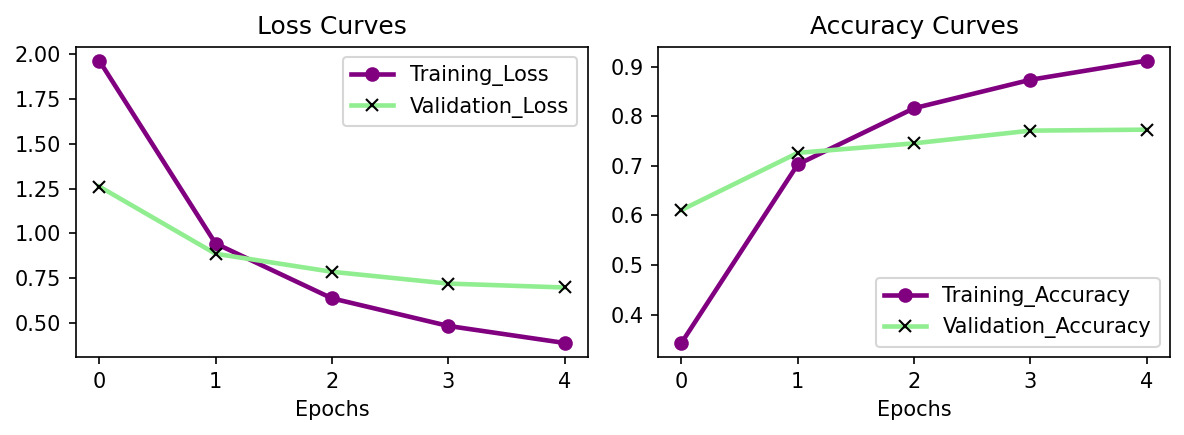

In [15]:
plot_loss_curves(resnet_history)

### **As seen from the above curves, if we look at the 1st Loss curve which is Training Loss and Validation Loss v/s epochs,... the training loss curve decreased more in comparision to validation loss curves that means it is performing quite poorly on validation loss curves implies... it's Overfitting!** 🙃

# 🏋️‍♂️**Now Creating and Testing EfficientNetB0 TensorFlow Hub Feature Extraction Model**

In [16]:
# Creating EfficientNetB0 Feature Extractor Model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compiling the EfficientNetB0 Model...
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                           metrics=['accuracy'])

EPOCHS=5
# Fitting on our EfficientNetB0 model to 10% of training data...
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=EPOCHS,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/2023-05-11 11:15:11 AM
Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 1.8619 - accuracy: 0.4413 - val_loss: 1.2892 - val_accuracy: 0.7364
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 1.0675 - accuracy: 0.7773 - val_loss: 0.8587 - val_accuracy: 0.8284
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.7625 - accuracy: 0.8293 - val_loss: 0.6880 - val_accuracy: 0.8484
Epoch 4/5
24/24 [==============================] - 16s 698ms/step - loss: 0.6090 - accuracy: 0.8693 - val_loss: 0.6034 - val_accuracy: 0.8580
Epoch 5/5
24/24 [==============================] - 17s 740ms/step - loss: 0.5137 - accuracy: 0.8893 - val_loss: 0.5489 - val_accuracy: 0.8668


In [17]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


# 📈 **Visualizing EfficientNetB0 Model...**

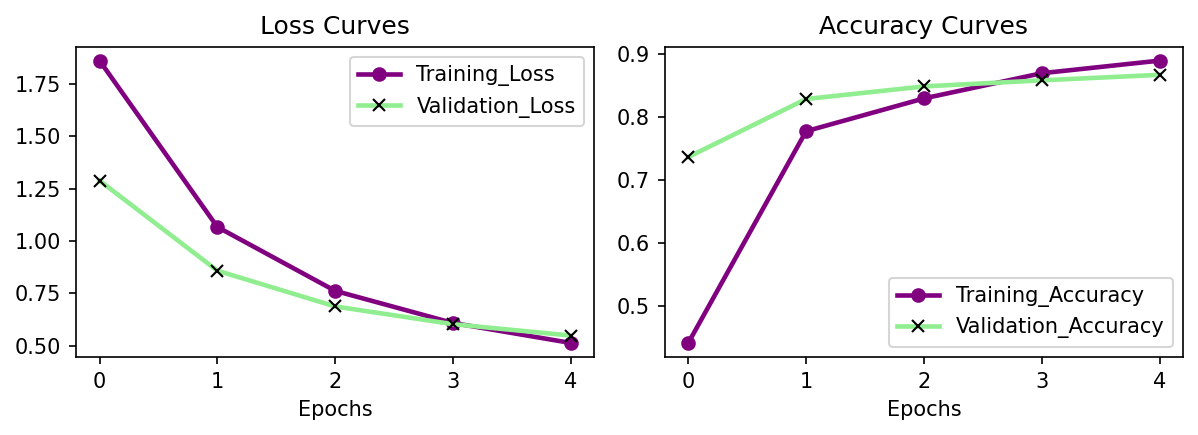

In [19]:
plot_loss_curves(efficientnet_history)

### **As seen from above plots, we can conclude that... EfficientNetB0 from the name itself is efficient in comparision to ResNetV2_50 architecture as well as from the above loss curves, its not even Overfitting!** 😀

In [20]:
efficientnet_model.layers

### **From above cell output we can see that there are 2 layers in our efficientnet_model which we have created above!**

In [25]:
print(f"Our EfficientNetB0 TensorFlow Hub Feature Extractor model has layers: {len(efficientnet_model.layers[0].weights)}")

Our EfficientNetB0 TensorFlow Hub Feature Extractor model has layers: 309


# 🛠️ **Now Comparing our model results using TensorBoard**

> ### 🔑 **Note:** When we upload things to TensorBoard.dev, our experiments are public. So, if we're running private experiments (things we don't want other to see) do not upload them to TensorBoard.dev

In [ ]:
# Upload TensorBoard dev records...

!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs. ResNet50V2" \
    --description "Comparing two different TF Hub Feature Extraction Model architectures using 10% of the Training data" \
    --one_shot 

## **Our TensorBoard experiments are uploaded publically here:  https://tensorboard.dev/experiment/udFdvY3pRImozJk0TZL2eQ/**

## **Now let's check out what TensorBoard experiments we have**

In [28]:
!tensorboard dev list

2023-05-11 12:08:06.668178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/udFdvY3pRImozJk0TZL2eQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub Feature Extraction Model architectures using 10% of the Training data
	Id                   udFdvY3pRImozJk0TZL2eQ
	Created              2023-05-11 11:55:10 (12 minutes ago)
	Updated              2023-05-11 11:55:15 (12 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5811169
Total: 1 experiment(s)


## **To delete an experiment...**

In [29]:
# !tensoboard dev delete --experiment_id udFdvY3pRImozJk0TZL2eQ

## **For Confirming the deletion by re-checking what experiments we have left, we will say...**

In [30]:
# !tensorboard dev list